# Multi-Layer Perceptron - Excess Return Forecasts - Practice Question Solutions

**Objectives**

* Train Feed-Forward Networks
  * Early Stopping
  * Activation Functions
  * Loss Functions
  * Optimizers
* Forecast Excess Returns
* Test the newest model proposed by academia

As we have done during the hands on session we are going to use the Goyal Welch dataset combined wuth Fred-MD to predict the SP500 excess returns.

Here is the task:
* Divide the dataset into three parts:
  * Train: 1959-03-31 : 2018-12-31
  * Validation : 2019-01-31 : 2019-12-31
  * Test : 2020-01-31 - 2020-12-31

* MinMaxScaler(feature_range=(-1,1)):
  * Fit and transform the train data using fit transform
  * Transform the validation set using information until the train data
  * Fit and transorm the train + validation set
  * Tranform the test set using the information available until 2019-31-31

* Build a 4 Layer Neural Net to test the latest academia tested model
  * 500 Epochs
  * Use Huber loss
  * Use the ReLU activation function
  * Use the Adam optimizer
  * First layer 68 neurons
  * Second layer 34 neurons
  * Third layer 12 neurons
  * Fourth layer 6 neurons
  * Run the above structure twice:
    * No early stopping
    * With early stopping (patience=200)
  * Show the in sample evaluation metrics for both models
  * Show the out of sample evaluation metrics for both models
  * Graph the forecasts produced against the actual.



## Data Import - Goyal Welch Excess Return Predictors

In [50]:
# !gdown --id 1OMWYlG7JXHN-PeBvQ1UBmfmlIuZP80fO

## Library Imports

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Normalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time

In [52]:
df_1 = pd.read_csv('merged_data.csv')

In [53]:
df_1.set_index('Date',inplace=True)

## Data Transformations

In [54]:
y = df_1['excess_returns']
X = df_1.drop('excess_returns', axis=1)

In [55]:
y.head()

Date
1959-03-01    0.001152
1959-04-01    0.038054
1959-05-01    0.021431
1959-06-01   -0.003225
1959-07-01    0.032004
Name: excess_returns, dtype: float64

In [56]:
X.head()

,CPIAUCSL,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCOLNVHFNM,DTCTHFNM,INVEST,D12,E12,b/m,lty,ntis,ltr,svar
Date,,,,,,,,,,,,,,,,,,,,,
1959-03-01,-0.000690,0.006430,0.007359,0.009410,-0.003423,0.008321,0.014303,0.006036,0.004899,0.000000,...,0.004929,0.004138,-0.014792,1.77000,3.11000,0.516860,0.0403,0.024984,0.0017,0.000492
1959-04-01,0.001380,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021077,0.014338,0.014542,0.015653,...,0.012134,0.006734,0.024929,1.77667,3.20667,0.498597,0.0414,0.024361,-0.0117,0.000493
1959-05-01,0.001723,0.005763,0.006616,0.012005,0.006797,0.007803,0.014950,0.008269,0.009583,0.004768,...,0.002828,0.002020,-0.015342,1.78333,3.30333,0.483077,0.0417,0.025887,-0.0005,0.000428
1959-06-01,0.000339,0.003102,0.002974,0.003708,-0.000051,0.009064,0.001144,0.007034,0.007126,-0.004768,...,0.009726,0.009007,-0.012252,1.79000,3.40000,0.483219,0.0419,0.026882,0.0010,0.000915
1959-07-01,-0.001034,-0.000589,-0.000764,-0.003427,0.012110,-0.000330,-0.024238,0.001167,0.008247,0.013056,...,-0.004631,-0.001000,0.029341,1.79667,3.41000,0.460823,0.0417,0.027141,0.0060,0.000488


Generating the splits- We are going to use Min Max Scaler and use a very specific strategy in scaling our variables.

In [57]:
y

Date
1959-03-01    0.001152
1959-04-01    0.038054
1959-05-01    0.021431
1959-06-01   -0.003225
1959-07-01    0.032004
                ...   
2020-08-01    0.071968
2020-09-01   -0.038251
2020-10-01   -0.026509
2020-11-01    0.109303
2020-12-01    0.041473
Name: excess_returns, Length: 742, dtype: float64

In [58]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [59]:
X_train =scaler.fit_transform(X.loc[:'2018'])
X_valid = scaler.transform(X.loc['2019-01-01':'2019-12-01'])

In [60]:
X_test_0 = scaler.fit_transform(X.loc[:'2019'])
X_test = scaler.transform(X.loc['2020-01-01':'2020-12-01'])

In [61]:
y_train = y.loc[:'2018']
y_valid = y.loc['2019-01-01':'2019-12-01']
y_test = y.loc['2020-01-01':'2020-12-01']

# Building the Neural Network

## Some Universal Parameters

In [62]:
# Set the Patience Level of Early Stopping
# Iterations increase with patience
patience = 200

early_stop = EarlyStopping(monitor='val_loss', patience=patience)

In [63]:
### Select Activation Function by Uncommenting ###

act_fn = 'relu'      # Rectified Linear Unit


In [64]:
### Select Loss Function by Uncommenting ###

loss = 'huber' #Huber Loss


In [65]:
### Select Optimizer by Uncommenting ###

optimizer = 'adam' # Adam


## Neural Net with 4 Layers

In [96]:
epochs = 500
normalizer = Normalization(axis=-1)
model_dnn4 = Sequential(normalizer) # scale the input variables
model_dnn4.add(Dense(68, activation=act_fn)) 
model_dnn4.add(Dense(34, activation=act_fn))
model_dnn4.add(Dense(12, activation=act_fn))
model_dnn4.add(Dense(6, activation=act_fn))
model_dnn4.add(Dense(1)) # output layer
model_dnn4.compile(loss=loss, optimizer=optimizer) # define the loss and optimizer
model_dnn4.fit(X_train,y_train,validation_data = (X_valid,y_valid),epochs=epochs) #fit the model

Epoch 1/500
 9/23 [==========>...................] - ETA: 0s - loss: 0.0214

2022-05-16 19:57:36.457142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 18ms/step - loss: 0.0095 - val_loss: 0.0013
Epoch 2/500
19/23 [=======================>......] - ETA: 0s - loss: 9.3223e-04

2022-05-16 19:57:36.936636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 6ms/step - loss: 9.1874e-04 - val_loss: 9.2142e-04
Epoch 3/500
23/23 [==============================] - 0s 6ms/step - loss: 8.8599e-04 - val_loss: 8.4571e-04
Epoch 4/500
23/23 [==============================] - 0s 7ms/step - loss: 8.6973e-04 - val_loss: 8.8308e-04
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 8.5328e-04 - val_loss: 9.0829e-04
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 8.4459e-04 - val_loss: 9.2950e-04
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 8.3466e-04 - val_loss: 9.1441e-04
Epoch 8/500
23/23 [==============================] - 0s 6ms/step - loss: 8.1156e-04 - val_loss: 9.6432e-04
Epoch 9/500
23/23 [==============================] - 0s 6ms/step - loss: 8.0427e-04 - val_loss: 8.9615e-04
Epoch 10/500
23/23 [==============================] - 0s 6ms/step - loss: 7.9622e-04 - val_loss: 9.5304e-04
Epoch 11/500
23/23 [============================

In [101]:
epochs = 500
normalizer = Normalization(axis=-1)
model_dnn4 = Sequential(normalizer) # scale the input variables
model_dnn4.add(Dense(68, activation=act_fn)) 
model_dnn4.add(Dense(34, activation=act_fn))
model_dnn4.add(Dense(12, activation=act_fn))
model_dnn4.add(Dense(6, activation=act_fn))
model_dnn4.add(Dense(1)) # output layer
model_dnn4.compile(loss=loss, optimizer=optimizer) # define the loss and optimizer
model_dnn4.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=epochs) #fit the model

Epoch 1/500
 9/23 [==========>...................] - ETA: 0s - loss: 0.0185

2022-05-16 19:59:17.130776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 11ms/step - loss: 0.0083 - val_loss: 9.8936e-04
Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 9.0146e-04 - val_loss: 7.7221e-04
Epoch 3/500


2022-05-16 19:59:17.463674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 6ms/step - loss: 8.7553e-04 - val_loss: 8.1353e-04
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 8.6373e-04 - val_loss: 8.4398e-04
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 8.5473e-04 - val_loss: 8.5110e-04
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 8.4845e-04 - val_loss: 8.1135e-04
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 8.4188e-04 - val_loss: 7.8002e-04
Epoch 8/500
23/23 [==============================] - 0s 7ms/step - loss: 8.3493e-04 - val_loss: 7.4685e-04
Epoch 9/500
23/23 [==============================] - 0s 7ms/step - loss: 8.2327e-04 - val_loss: 7.9372e-04
Epoch 10/500
23/23 [==============================] - 0s 6ms/step - loss: 8.1098e-04 - val_loss: 8.0440e-04
Epoch 11/500
23/23 [==============================] - 0s 6ms/step - loss: 8.0208e-04 - val_loss: 7.6386e-04
Epoch 12/500
23/23 [===========================

In [78]:
epochs = 500
normalizer = Normalization(axis=-1)
model_dnn4_es = Sequential(normalizer) # scale the input variables
model_dnn4_es.add(Dense(68, activation=act_fn)) 
model_dnn4_es.add(Dense(34, activation=act_fn))
model_dnn4_es.add(Dense(12, activation=act_fn))
model_dnn4_es.add(Dense(6, activation=act_fn))
model_dnn4_es.add(Dense(1)) # output layer
model_dnn4_es.compile(loss=loss, optimizer=optimizer) # define the loss and optimizer
model_dnn4_es.fit(X_train, y_train, validation_data = (X_valid,y_valid), epochs=epochs, callbacks=[early_stop]) #fit the model


Epoch 1/500
 9/23 [==========>...................] - ETA: 0s - loss: 0.0175

2022-05-16 17:15:39.043019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 12ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 2/500
23/23 [==============================] - 0s 7ms/step - loss: 9.0249e-04 - val_loss: 0.0011
Epoch 3/500


2022-05-16 17:15:39.365355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 6ms/step - loss: 8.7908e-04 - val_loss: 0.0011
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 8.6685e-04 - val_loss: 0.0011
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 8.5322e-04 - val_loss: 0.0010
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 8.4480e-04 - val_loss: 0.0011
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 8.3328e-04 - val_loss: 0.0011
Epoch 8/500
23/23 [==============================] - 0s 6ms/step - loss: 8.2147e-04 - val_loss: 0.0010
Epoch 9/500
23/23 [==============================] - 0s 6ms/step - loss: 8.1283e-04 - val_loss: 0.0010
Epoch 10/500
23/23 [==============================] - 0s 6ms/step - loss: 8.0342e-04 - val_loss: 0.0010
Epoch 11/500
23/23 [==============================] - 0s 6ms/step - loss: 7.9634e-04 - val_loss: 0.0011
Epoch 12/500
23/23 [==============================] - 0s 7ms/step - loss: 7.9258e-0

In [90]:
model_dnn4.evaluate(X_test, y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.0673


0.067254438996315

In [91]:
model_dnn4_es.evaluate(X_test, y_test)

1/1 [==============================] - 0s 13ms/step - loss: 0.0645


0.06450894474983215

In [102]:
y_pred_nn4 = model_dnn4.predict(X_test)
y_pred_nn4_es = model_dnn4_es.predict(X_test)

2022-05-16 20:00:54.726264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [103]:
y_pred_nn4

array([[ 0.06175392],
       [-0.04586355],
       [-0.25055888],
       [ 0.00509609],
       [-0.42551202],
       [-0.49169683],
       [-0.0125751 ],
       [ 0.08308136],
       [ 0.0407354 ],
       [-0.00069477],
       [ 0.00719424],
       [ 0.03542385]], dtype=float32)

Text(0.5, 1.0, 'NeuralNet Test data')

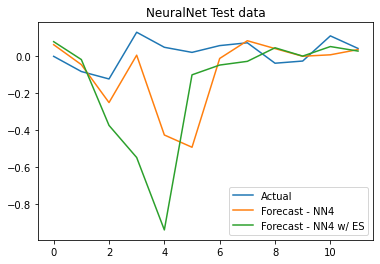

In [104]:
X_grid = np.arange(len(X_test))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid, y_test)


plt.plot(X_grid, y_pred_nn4)
plt.plot(X_grid, y_pred_nn4_es)
plt.legend(('Actual','Forecast - NN4', 'Forecast - NN4 w/ ES'))
plt.title('NeuralNet Test data')
#plt.savefig('NeuralNet Test')